In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Время выполнения функции

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test , y_train , y_test = train_test_split (X, y, test_size =0.3, random_state = 42)

depths = list(range(1, 11))
execution_times = []
accuracies = []
                                                       
for depth in depths:
    start_time = time.time()
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test , y_pred)
    accuracies.append(accuracy)
    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append(execution_time)

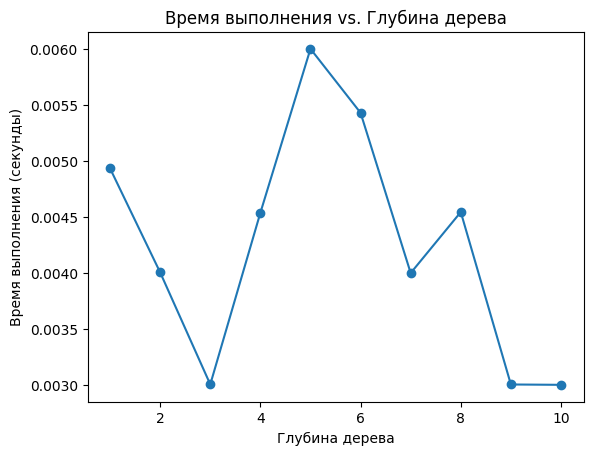

In [13]:
plt.plot(depths, execution_times , marker='o', linestyle = '-')
plt.title("Время выполнения vs. Глубина дерева")
plt.xlabel("Глубина дерева")
plt.ylabel("Время выполнения (секунды)")
plt.show()

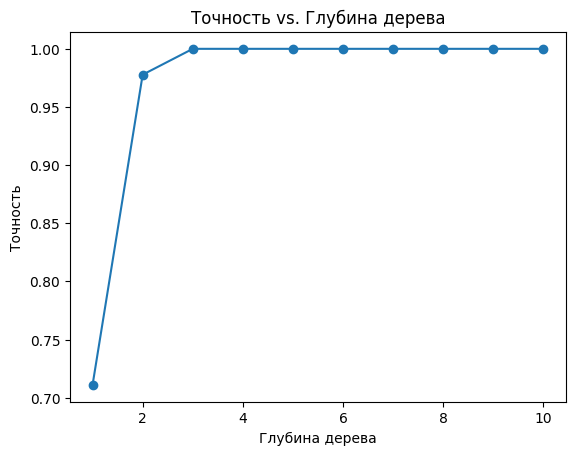

In [14]:
plt.plot(depths, accuracies, marker='o', linestyle = '-')
plt.title("Точность vs. Глубина дерева")
plt.xlabel("Глубина дерева")
plt.ylabel("Точность")
plt.show()

### Ускорение Pandas и NumPy

#### Numba

In [15]:
import numpy as np
import numba

In [16]:
df = pd.DataFrame(np.random.randint(0,100,size=(100000, 4)),columns=['a', 'b', 'c', 'd'])
df.head()

a   b   c   d
0  76  19  53   8
1   0  63   4  94
2  89  88  50  43
3  71  74  70  26
4   1  53  70  56

In [17]:
df.shape

(100000, 4)

In [18]:
def multiply(x):
    return x * 5

In [19]:
@numba.vectorize
def multiply_numba(x):
    return x * 5

In [24]:
%timeit df['a'].apply(multiply)

60.3 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit df['a'] * 5

349 µs ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%timeit multiply_numba(df['a'].to_numpy())

230 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
def square_mean(row):
    row = np.power(row, 2)
    return np.mean(row)

In [12]:
%timeit df['new_col'] = df.apply(square_mean, axis=1)

13.7 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
@numba.njit
def square_mean_numba(arr):
    res = np.empty(arr.shape[0])
    arr = np.power(arr, 2)
    for i in range(arr.shape[0]):
        res[i] = np.mean(arr[i])
    return res

In [14]:
%timeit df['new_col'] = square_mean_numba(df.to_numpy())

3.47 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multiprocessing

In [30]:
import kagglehub
path = kagglehub.dataset_download("therohk/million-headlines")
data = pd.read_csv(path + '\\abcnews-date-text.csv')

In [31]:
data.shape

(1244184, 2)

In [32]:
data.head()

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [36]:
line = data.iloc[0,1].split()
words = []
for word in line:
    words.append(len(word))

In [42]:
line = data.iloc[0,1].split()
words = [len(word) for word in line]
sum(words)/len(words)

7.5

In [43]:
def mean_word_len(line):
    for i in range(6):
        words = [len(word) for word in line.split()]
        res = sum(words) / len(words)
    return res

In [44]:
data['headline_text'].apply(mean_word_len)

0          7.500000
1          4.875000
2          5.714286
3          3.555556
4          5.571429
             ...   
1244179    4.666667
1244180    5.250000
1244181    5.857143
1244182    6.500000
1244183    4.000000
Name: headline_text, Length: 1244184, dtype: float64

In [ ]:
def compute_avg_word(df):
    return df['headline_text'].apply(mean_word_len)

In [21]:
%timeit data['headline_text'].apply(mean_word_len)

10.9 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
from multiprocessing import Pool

In [18]:
def apply_parallel(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
apply_parallel(data, compute_avg_word, n_cores = 8)

C:\Anaconda\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#### Pandarallel

In [49]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [17]:
%timeit data['headline_text'].parallel_apply(mean_word_len)

6.25 s ± 467 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Swifter

In [50]:
import swifter

In [51]:
%timeit data['headline_text'].swifter.allow_dask_on_strings().apply(mean_word_len)

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/17 [00:00<?, ?it/s]

18.1 s ± 1.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Dask

In [52]:
import dask.dataframe as dd

In [55]:
from distributed import Client
client = Client(n_workers=4)

C:\Anaconda\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57791 instead
  warnings.warn(


In [56]:
%timeit dd.read_csv(path + '\\abcnews-date-text.csv', header=0)

48.7 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%timeit pd.read_csv(path + '\\abcnews-date-text.csv', header=0)

4.96 s ± 730 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
dd.from_pandas(data['headline_text'], npartitions = 4).apply(mean_word_len, meta = (float)).compute()

C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0         7.500000
1         4.875000
2         5.714286
3         3.555556
4         5.571429
            ...   
311041    4.200000
311042    6.166667
311043    5.857143
311044    6.000000
311045    5.666667
Name: headline_text, Length: 311046, dtype: float64

In [37]:
%timeit dd.from_pandas(data['headline_text'], npartitions=8).apply(mean_word_len, meta = (float)).compute()

C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
C:\Anaconda\Lib\site-packages\distributed\client.py:3125: UserWarning: Sending large graph of size 58.48 MiB.
This may cause some slowdown.


5.5 s ± 75.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
